## Creating object for BAGraph and it's connected version to use during the simulation

In [33]:
import numpy as np
import networkx as nx
from networkx import DiGraph

class BAGraph(DiGraph):
    def __init__(self, m: int):
        DiGraph.__init__(self)
        self._m = m
        self.add_nodes_from(range(m))
    
    @property
    def m(self):
        """
        The number of new edges for each new node
        """
        return self._m
    
    @property
    def adjacency_matrix(self):
        """
        Returns the adjacency matrics of the graph
        """
        return nx.adjacency_matrix(self)
    
    @property
    def timearrivals(self):
        """
        Returns the time of arrival for each node
        """
        time_arrivals = [0]*self.m + list(range(1, len(self.nodes) - self.m + 1))
        return {i: time_arrivals[i] for i in range(len(self.nodes))}
    
    @property
    def indegrees(self):
        """
        Returns the indegrees for each node
        """
        return dict(self.in_degree)
    
    @property
    def eigvect_centrality(self):
        """
        Returns eigenvector centrality
        """
        return nx.eigenvector_centrality_numpy(self, tol=1e-03) # don't know why but without this tol parameter I get some errors
    
    @property
    def pagerank(self,  
                 alpha:float = 0.85
                 )->dict:
        """
        Returns the page rank value of each node in `dict` format
        """
        return nx.pagerank(self, alpha = alpha)
    
    def calcProbabilities(self) -> np.ndarray:
        """
        Calculates the attachment probabilities for each node
        when the new node comes in.
        """
        if len(self.edges) == 0:
            return np.ones(len(self.nodes))/len(self.nodes)
        sum_degree = 2*len(self.edges)
        return np.array(list(dict(self.degree).values())) / sum_degree
     
    def addNode(self):
        """
        Adds a new node to the graph
        """
        probs = self.calcProbabilities()
        chosen_nodes = np.random.choice(list(self.nodes),
                                       self._m,
                                       replace = False,
                                       p = probs)
        self.add_node(len(self.nodes))
        for node in chosen_nodes:
            self.add_edge(list(self.nodes)[-1],node)
            
    def buildGraph(self, 
                   n: int):
        """
        Builds the Barabasi-Albert graph with `n` new nodes
        """
        for _ in range(n):
            self.addNode()

class ConnectedBAGraph(BAGraph):
    def __init__(self, m = 1, n = 500):
        BAGraph.__init__(self, m)
        self.buildGraph(n)

## Creating simulation task object to run the simulations in a highly customizable way

In [41]:
from typing import List
from enum import Enum

# in order to get properties and to make it possible with the usage of an Enum class we need a wrapper that
# returns the property for a given instance
class TargetWrapper:
    def __init__(self, property_):
        self.p = property_
    
    def __call__(self, instance):
        return self.p.fget(instance)

class Target(Enum):
    pagerank = TargetWrapper(BAGraph.pagerank)
    indegrees = TargetWrapper(BAGraph.indegrees)
    arrivaltime = TargetWrapper(BAGraph.timearrivals)
    eigvect_centrality = TargetWrapper(BAGraph.eigvect_centrality)


def calc_correlation(x_sample, y_sample):
    if not isinstance(x_sample, np.ndarray):
        x_sample = np.array(x_sample, dtype = float)
    if not isinstance(y_sample, np.ndarray):
        y_sample = np.array(y_sample, dtype = float)

    assert len(x_sample) == len(y_sample), "Sample lengths are not the same"

    xy = x_sample*y_sample
    cov = np.mean(xy) - np.mean(x_sample)*np.mean(y_sample)
    if all(w := (np.std(x_sample), np.std(y_sample))):
        return cov/np.prod(w)
    else:
        return 0


class SimulationTask:
    def __init__(self, 
                 m: int = 4,
                 num_graphs: int = 20, 
                 n_list: List[int] = None,
                 num_random: int = 10):
        if n_list is None:
            self._n_list = [1,5,10,20,50,100,200,500,1000]
        else:
            self._n_list = n_list
        
        self._m = m
        self._n_graph = num_graphs
        self.graph_list = []
        self.num_random = num_random
        self._result = {}

    @property
    def result(self):
        """
        In the result dictionary there are two levels of keys:
        - the first key corresponds to the `n` the given simulation used
        - `target1-target2` where `target1` and `target2` are part of the examined metrics. 
        
        The values of the dict are lists containing the estimated correlations based on the graphs and the random indeces.
        """
        return self._result

    def getGraphs(self, n: int):
        self.graph_list = [ConnectedBAGraph(m = self._m, n = n) for _ in range(self._n_graph)]
    
    def getCorrelations(self, 
                        n: int, 
                        target1: str, 
                        target2: str
                        )->List[float]:
        correlations = []
        for _ in range(self.num_random):
            rand_index = np.random.choice(range(n + self._m))
            t1_list, t2_list = [], []
            for g in self.graph_list:
                t1_list.append(Target[target1].value(g)[rand_index])
                t2_list.append(Target[target2].value(g)[rand_index])

            correlations.append(calc_correlation(t1_list, t2_list))

        return correlations
    
    def __call__(self):
        """
        Runs the simulation part and fills the result dictionary
        """
        targets = [t.name for t in Target]
        for n in self._n_list:
            print(n)
            self._result[n] = {}
            self.getGraphs(n)
            for i, target1 in enumerate(targets):
                for j, target2 in enumerate(targets):
                    if i >= j:
                        continue
                    
                    newkey = target1 + '-' + target2
                    print(newkey)
                    self._result[n][newkey] = self.getCorrelations(n, target1, target2)

## Results for $m = 1$ case

In [36]:
st = SimulationTask(m = 1, num_graphs = 50, n_list = [100, 300, 500, 700, 900, 1100, 1300, 1500], num_random = 50)
st()


100
pagerank-indegrees
pagerank-arrivaltime
pagerank-eigvect_centrality
indegrees-arrivaltime
indegrees-eigvect_centrality
arrivaltime-eigvect_centrality
300
pagerank-indegrees
pagerank-arrivaltime
pagerank-eigvect_centrality
indegrees-arrivaltime
indegrees-eigvect_centrality
arrivaltime-eigvect_centrality
500
pagerank-indegrees
pagerank-arrivaltime
pagerank-eigvect_centrality
indegrees-arrivaltime
indegrees-eigvect_centrality
arrivaltime-eigvect_centrality
700
pagerank-indegrees
pagerank-arrivaltime
pagerank-eigvect_centrality
indegrees-arrivaltime
indegrees-eigvect_centrality
arrivaltime-eigvect_centrality
900
pagerank-indegrees
pagerank-arrivaltime
pagerank-eigvect_centrality
indegrees-arrivaltime
indegrees-eigvect_centrality
arrivaltime-eigvect_centrality
1100
pagerank-indegrees
pagerank-arrivaltime
pagerank-eigvect_centrality
indegrees-arrivaltime
indegrees-eigvect_centrality
arrivaltime-eigvect_centrality
1300
pagerank-indegrees
pagerank-arrivaltime
pagerank-eigvect_centrality
in

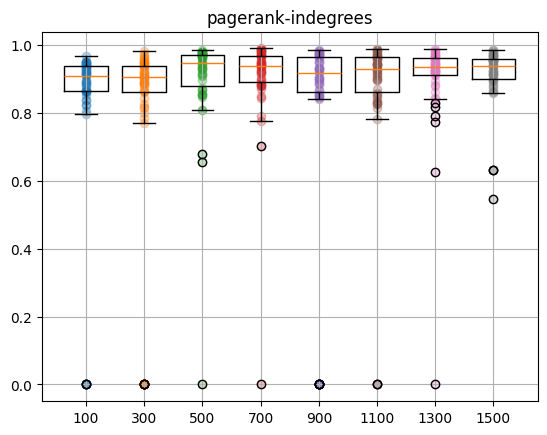

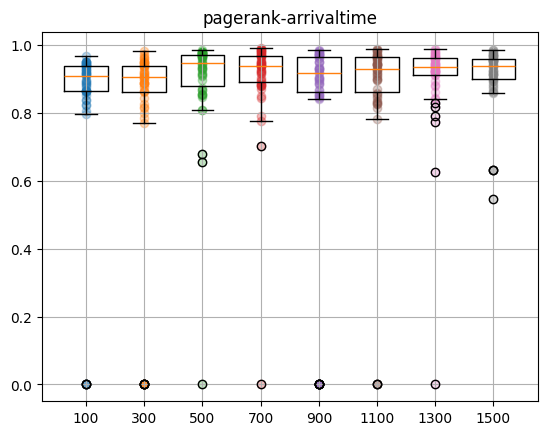

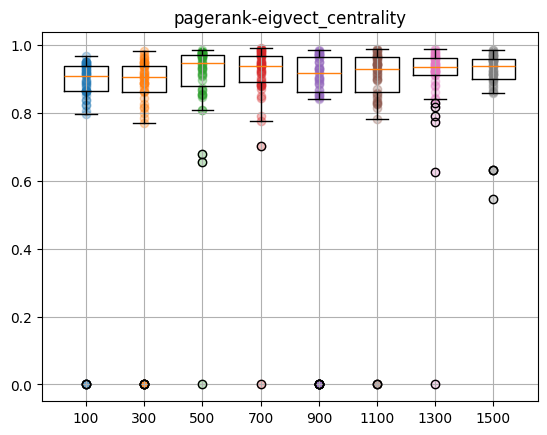

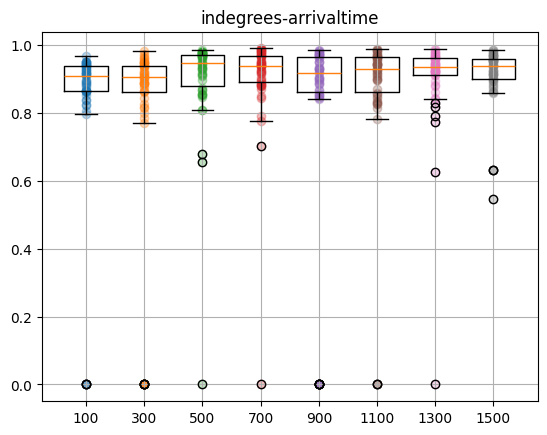

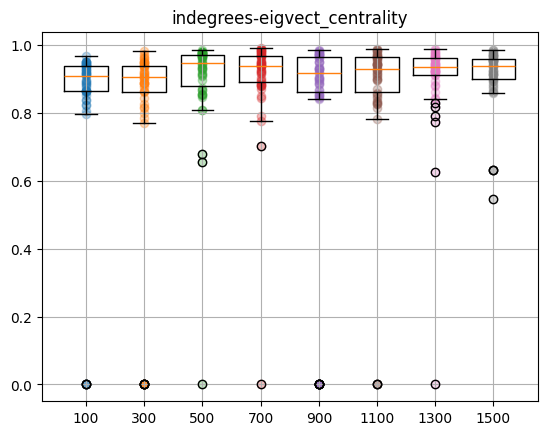

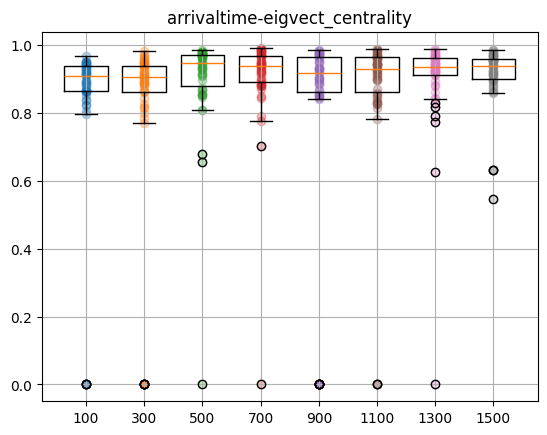

In [37]:
import matplotlib.pyplot as plt

targets = [t.name for t in Target]
for i, target1 in enumerate(targets):
    for j, target2 in enumerate(targets):
        if i >= j:
            continue

        key = target1 + '-' + target2
        plt.title(key)
        matrix = []
        for n in [100, 300, 500, 700, 900, 1100, 1300, 1500]:
            data = st.result[n]['pagerank-indegrees']
            matrix.append(data)
            plt.scatter([n]*len(data), data, alpha = 0.3, marker = 'o')
        matrix = np.array(matrix).T
        plt.boxplot(matrix, widths = 150, positions = [100, 300, 500, 700, 900, 1100, 1300, 1500])
        plt.grid()
        plt.show()

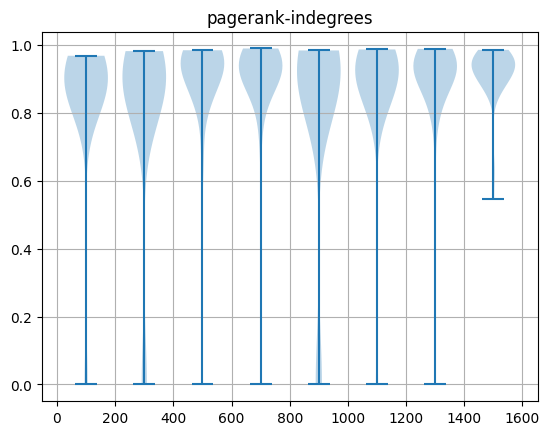

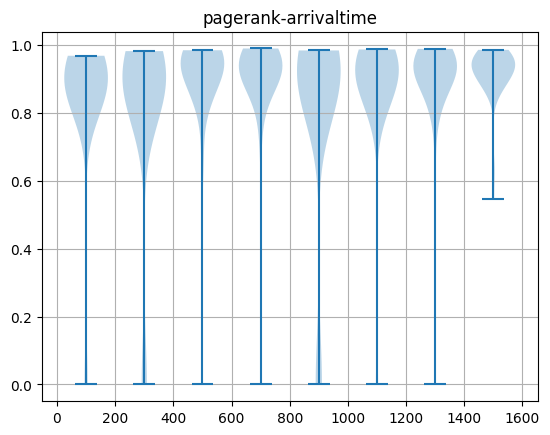

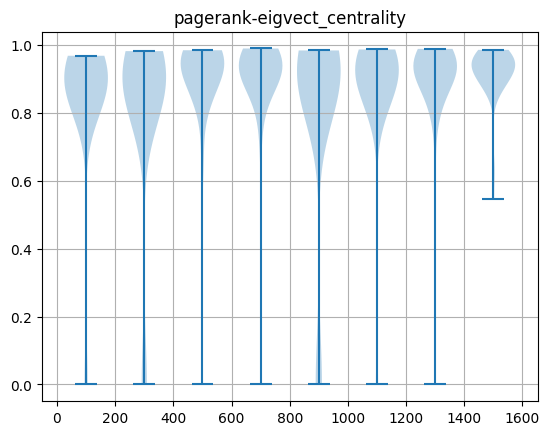

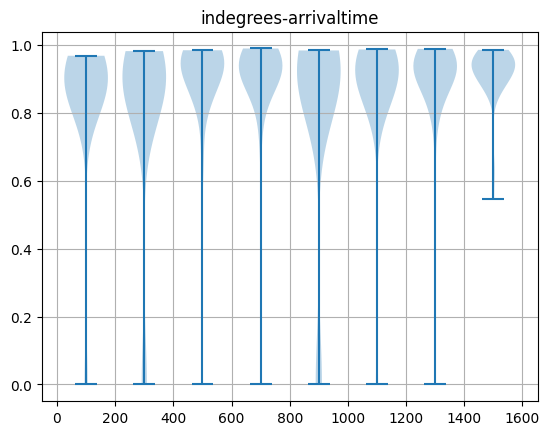

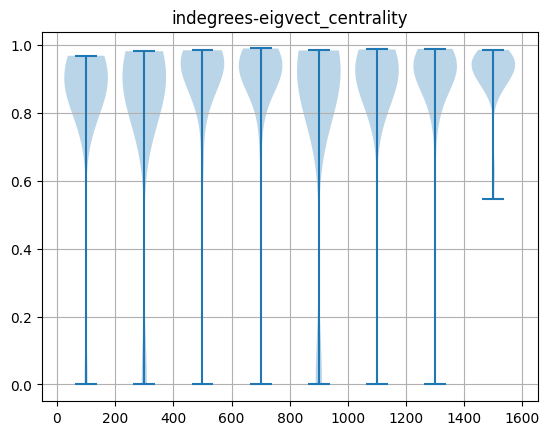

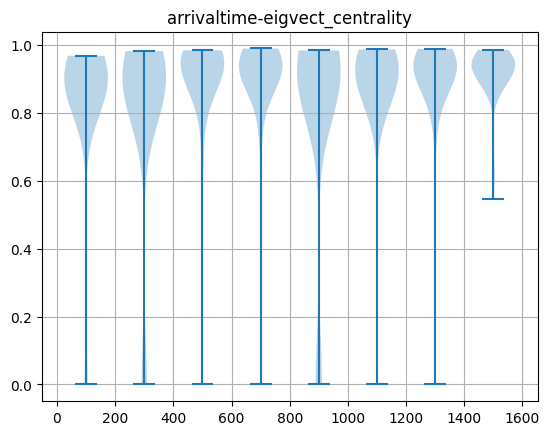

In [38]:
import matplotlib.pyplot as plt

targets = [t.name for t in Target]
for i, target1 in enumerate(targets):
    for j, target2 in enumerate(targets):
        if i >= j:
            continue

        key = target1 + '-' + target2
        plt.title(key)
        matrix = []
        for n in [100, 300, 500, 700, 900, 1100, 1300, 1500]:
            data = st.result[n]['pagerank-indegrees']
            matrix.append(data)
           
        matrix = np.array(matrix).T
        plt.violinplot(matrix, widths = 150, positions = [100, 300, 500, 700, 900, 1100, 1300, 1500])
        plt.grid()
        plt.show()

## Results for $m = 4$ case

In [39]:
st = SimulationTask(m = 4, num_graphs = 50, n_list = [100, 300, 500, 700, 900, 1100, 1300, 1500], num_random = 50)
st()

100
pagerank-indegrees
pagerank-arrivaltime
pagerank-eigvect_centrality
indegrees-arrivaltime
indegrees-eigvect_centrality
arrivaltime-eigvect_centrality
300
pagerank-indegrees
pagerank-arrivaltime
pagerank-eigvect_centrality
indegrees-arrivaltime
indegrees-eigvect_centrality
arrivaltime-eigvect_centrality
500
pagerank-indegrees
pagerank-arrivaltime
pagerank-eigvect_centrality
indegrees-arrivaltime
indegrees-eigvect_centrality
arrivaltime-eigvect_centrality
700
pagerank-indegrees
pagerank-arrivaltime
pagerank-eigvect_centrality
indegrees-arrivaltime
indegrees-eigvect_centrality
arrivaltime-eigvect_centrality
900
pagerank-indegrees
pagerank-arrivaltime
pagerank-eigvect_centrality
indegrees-arrivaltime
indegrees-eigvect_centrality
arrivaltime-eigvect_centrality
1100
pagerank-indegrees
pagerank-arrivaltime
pagerank-eigvect_centrality
indegrees-arrivaltime
indegrees-eigvect_centrality
arrivaltime-eigvect_centrality
1300
pagerank-indegrees
pagerank-arrivaltime
pagerank-eigvect_centrality
in

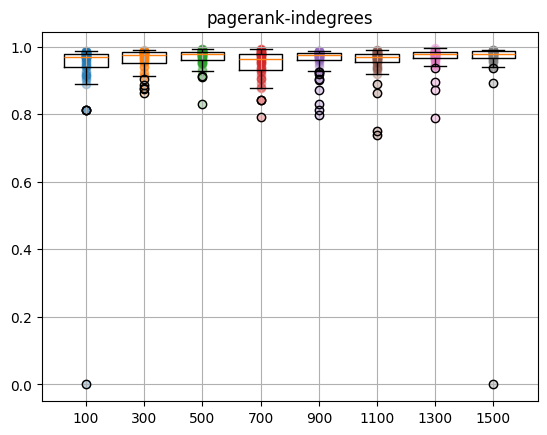

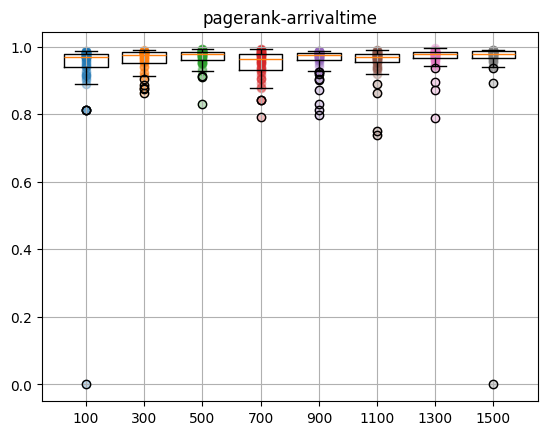

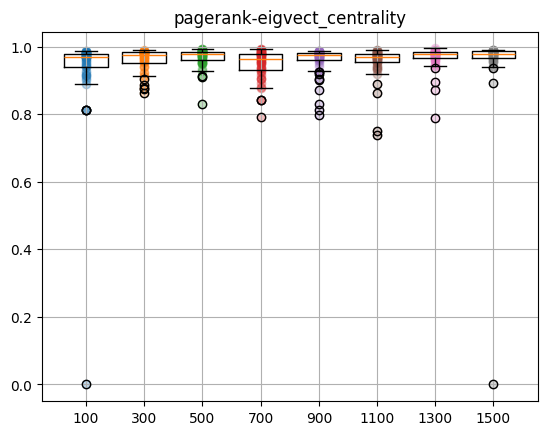

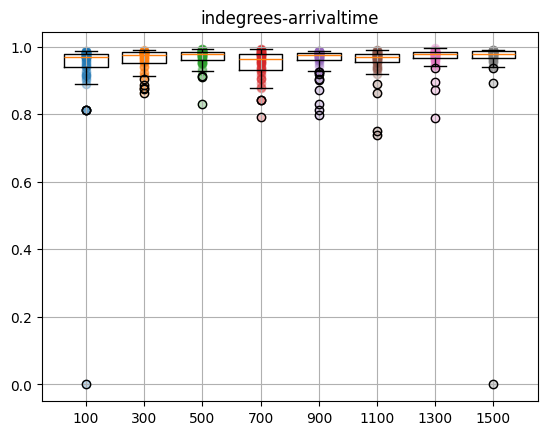

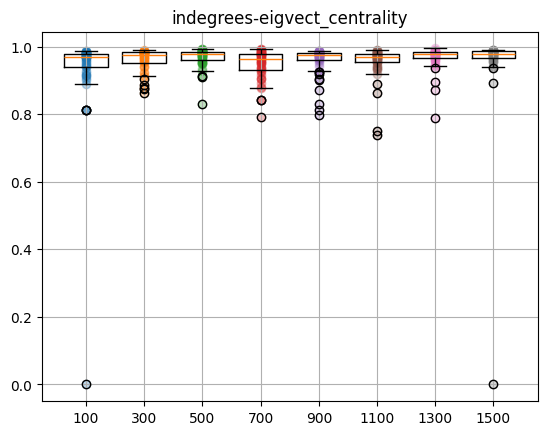

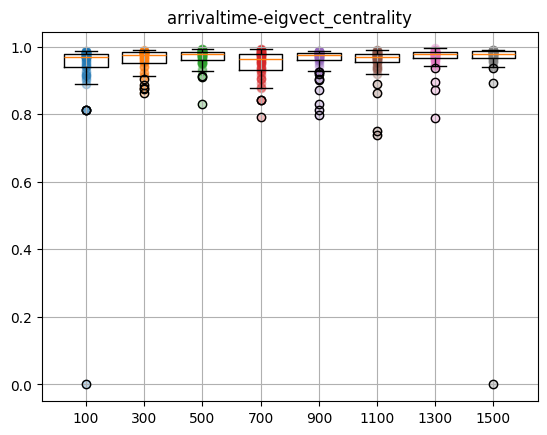

In [40]:
import matplotlib.pyplot as plt

targets = [t.name for t in Target]
for i, target1 in enumerate(targets):
    for j, target2 in enumerate(targets):
        if i >= j:
            continue

        key = target1 + '-' + target2
        plt.title(key)
        matrix = []
        for n in [100, 300, 500, 700, 900, 1100, 1300, 1500]:
            data = st.result[n]['pagerank-indegrees']
            matrix.append(data)
            plt.scatter([n]*len(data), data, alpha = 0.3, marker = 'o')
        matrix = np.array(matrix).T
        plt.boxplot(matrix, widths = 150, positions = [100, 300, 500, 700, 900, 1100, 1300, 1500])
        plt.grid()
        plt.show()

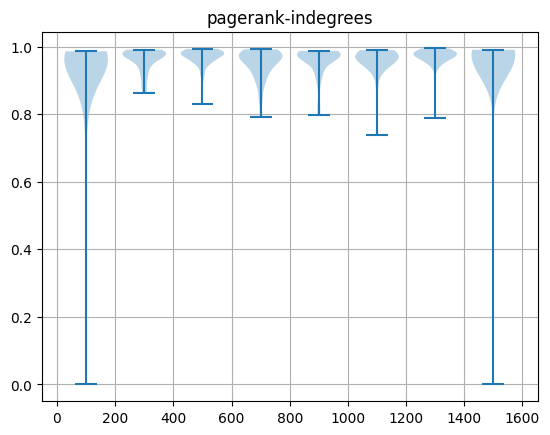

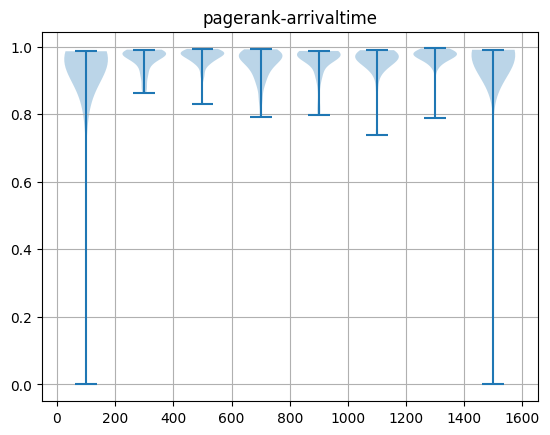

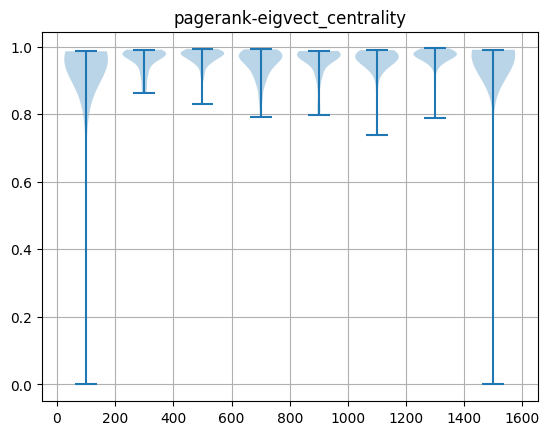

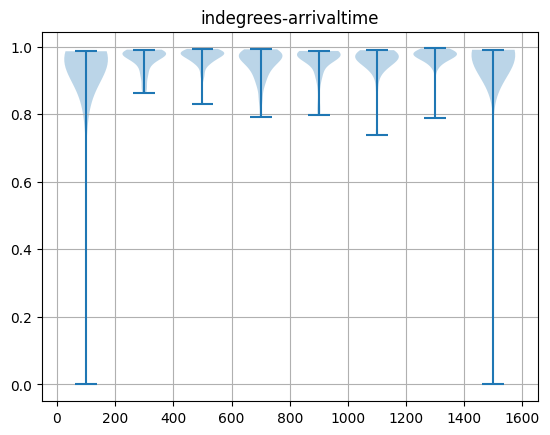

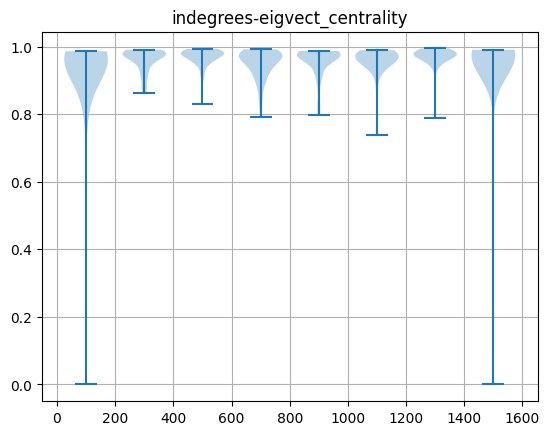

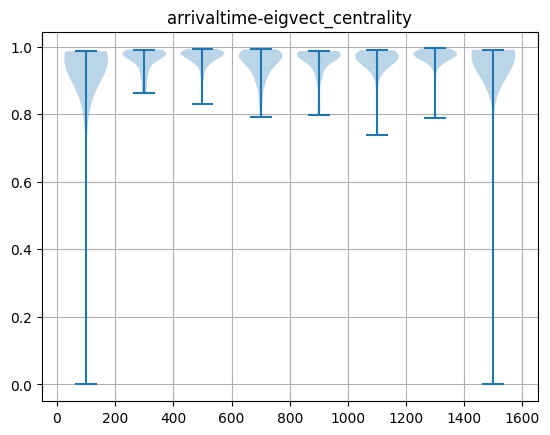

In [42]:
import matplotlib.pyplot as plt

targets = [t.name for t in Target]
for i, target1 in enumerate(targets):
    for j, target2 in enumerate(targets):
        if i >= j:
            continue

        key = target1 + '-' + target2
        plt.title(key)
        matrix = []
        for n in [100, 300, 500, 700, 900, 1100, 1300, 1500]:
            data = st.result[n]['pagerank-indegrees']
            matrix.append(data)
           
        matrix = np.array(matrix).T
        plt.violinplot(matrix, widths = 150, positions = [100, 300, 500, 700, 900, 1100, 1300, 1500])
        plt.grid()
        plt.show()